In [8]:
with open("tinyshakespeare.txt") as f:
    text = f.read()

print(f"Total number of characters: {len(text):,}")


Total number of characters: 1,115,394


In [6]:
print(text[:1000])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [10]:
chars = sorted(set(text))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


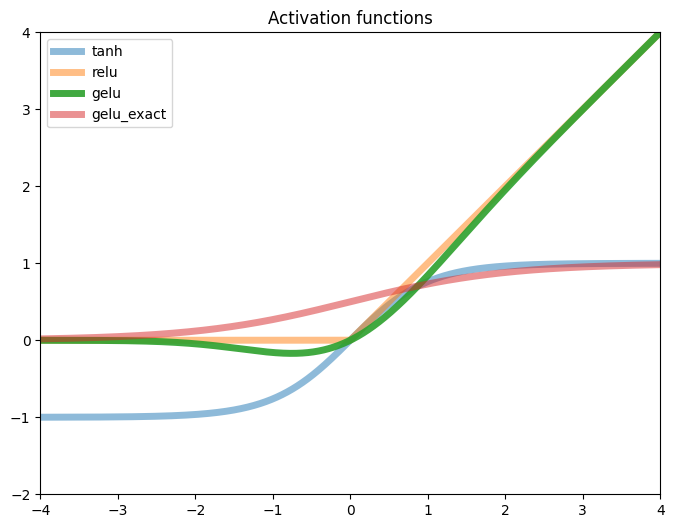

In [14]:
## Tokenize - we want to turn the input data into some kind of numeric representation
# In our case, as a character level language model, we want representations of characters.
# Alternative libraries: Google's SentencePiece, OpenAI's tiktoken
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for i, s in enumerate(chars)}


def encode(text: str) -> list[int]:
    """Encode a piece of text into its numerical form: a list of integers."""
    return [stoi[c] for c in text]


def decode(enc: list[int]) -> str:
    """Decode a list of integers into a string/piece of text."""
    return "".join(itos[i] for i in enc)


ex = "Hello GPT!"
ex = "hii there"
print(f"Example:  '{ex}'")
print("encoding:", encode(ex))
print("decoding:", decode(encode(ex)))


Example:  'hii there'
encoding: [46, 47, 47, 1, 58, 46, 43, 56, 43]
decoding: hii there


In [15]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])  # encoded version the the 1000 characters we printed above, now as ints


torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [90]:
torch.manual_seed(1337)

# N = len(text)
# n = int(0.8 * N)
# m = int(0.1 * N)
# train_data = data[:n]
# val_data = data[n:n+m]
# test_data = data[n+m:]
# print(f"{train_data.shape=}, {val_data.shape}, {test_data.shape}")

N = len(text)
n = int(0.9 * N)
train_data = data[:n]
val_data = data[n:]
print(f"{train_data.shape=}, {val_data.shape}")


train_data.shape=torch.Size([1003854]), torch.Size([111540])


* We train on random samples from the entire text.
* We predefine a maximum context length (=block size): the model will never see more history than this in order to predict the next element in the sequence
* For each random sample, we can use masking to create block_size examples, each with different context lengths: `0, 1, ... block_size`

In [91]:
block_size = 8
train_data[: block_size + 1]  # +1 because we need the next character as target to predict, given block_size context


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [92]:
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
for i in range(block_size):
    context = x[: i + 1]
    target = y[i]
    print(f"Input context: {str(context.tolist()):<32} -> {target}")


Input context: [18]                             -> 47
Input context: [18, 47]                         -> 56
Input context: [18, 47, 56]                     -> 57
Input context: [18, 47, 56, 57]                 -> 58
Input context: [18, 47, 56, 57, 58]             -> 1
Input context: [18, 47, 56, 57, 58, 1]          -> 15
Input context: [18, 47, 56, 57, 58, 1, 15]      -> 47
Input context: [18, 47, 56, 57, 58, 1, 15, 47]  -> 58


In [ ]:
# Now we need to add a batch dimension, to pull the many samples into one batch. Only done for efficiency reasons.
# (We don't want to mingle their statistics though, so probably why we use layerNorm instead of BatchNorm.)


In [168]:
torch.manual_seed(1337)
batch_size = 4  # how many random sequences we sample from the text
block_size = 8  # the max context length for a sample


def get_batch(split: str, batch_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Generate a random batch of inputs/targets from the named split."""
    assert split in ("train", "val"), f"split must be either 'train' or 'val', received {split}"
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, size=(batch_size,))  # generate batch_size random starting indices
    x = torch.stack([data[i : i + block_size] for i in ix], dim=0)
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix], dim=0)
    return x, y


Xb, Yb = get_batch("train", batch_size=4)

print(f"{Xb.shape=}\n{Xb=}")
print(f"{Yb.shape=}\n{Yb=}")
print()


Xb.shape=torch.Size([4, 8])
Xb=tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
Yb.shape=torch.Size([4, 8])
Yb=tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])



In [94]:
for b in range(batch_size):
    print(f"Batch: {b}")
    for i in range(block_size):
        context = Xb[b, : i + 1]
        target = Yb[b, i]
        print(f"Input context: {str(context.tolist()):<32} -> {target}")
    print("------------------")


Batch: 0
Input context: [24]                             -> 43
Input context: [24, 43]                         -> 58
Input context: [24, 43, 58]                     -> 5
Input context: [24, 43, 58, 5]                  -> 57
Input context: [24, 43, 58, 5, 57]              -> 1
Input context: [24, 43, 58, 5, 57, 1]           -> 46
Input context: [24, 43, 58, 5, 57, 1, 46]       -> 43
Input context: [24, 43, 58, 5, 57, 1, 46, 43]   -> 39
------------------
Batch: 1
Input context: [44]                             -> 53
Input context: [44, 53]                         -> 56
Input context: [44, 53, 56]                     -> 1
Input context: [44, 53, 56, 1]                  -> 58
Input context: [44, 53, 56, 1, 58]              -> 46
Input context: [44, 53, 56, 1, 58, 46]          -> 39
Input context: [44, 53, 56, 1, 58, 46, 39]      -> 58
Input context: [44, 53, 56, 1, 58, 46, 39, 58]  -> 1
------------------
Batch: 2
Input context: [52]                             -> 58
Input context: [52, 5

In [97]:
Xb.shape, Yb.shape


(torch.Size([4, 8]), torch.Size([4, 8]))

In [178]:
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)


class BigramLM(nn.Module):
    """Implements the bigram language model as a LUT of learned vectors for each bigram."""

    def __init__(self, vocab_size: int) -> None:
        super().__init__()
        # Define a LUT for the bigram embeddings
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_size)

    def forward(self, idx, targets=None):
        """Forward pass of the bigram language model.

        1. index to get embeddings of each input character (given as their indices idx)
        2. treat those embeddings as the logits across the vocab, thus predicted likelihood of the next char

        Args:
          idx: indices of the input character sequences, (B, block_size).
          targets: indices of the characters that are to be predicted, (B, block_size). [Optional]

        Returns:
          the predicted logits, and the loss value if targets were given.  shape (batch*block, embedding_size)
        """
        logits = self.token_embedding_table(idx)  # returns (B, block_size, vocab_size) a.k.a. (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(
                B * T, C
            )  # torch's cross_entropy requires shape (N, C), all logits for a sample as final dim
            # compute the loss - use cross entropy loss (negative log likelihood)
            targets = targets.view(B * T)  # make the shape of targets match logits for F.cross_entropy to work
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """Given an existing context, generate the next tokens based on likeliness of the bigram model."""
        for _ in range(max_new_tokens):
            # compute logits from the model - loss is None as we don't supply targets
            logits, loss = self(idx)
            assert loss is None
            # For the bigram model, we only look at the previous character, so take that out and drop a dim
            logits = logits[:, -1, :]  # (B, T, C) becomes (B, C)
            # squash logits into normalised confidences (~probabilities)
            probs = F.softmax(logits, dim=1)  # (B, C)
            # Now we can sample from the probability distribution
            new_idx = torch.multinomial(probs, 1)  # (B, 1) --  if pred horizon >1, maybe us replacement=True
            # Append the newly sampled character indices to the context window before predicting in next iteration
            idx = torch.cat([idx, new_idx], dim=1)  # (B, T+1)

        return idx


# Evaluate model with targets
model = BigramLM(vocab_size)
logits, loss = model(Xb, Yb)
print(logits.shape, loss)

# When evaluated without passing targets
logits, loss = model(Xb)
print(logits.shape, loss is None)


torch.Size([32, 65]) tensor(4.8786, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 65]) True


In [182]:
# Seeding character generation with newline (\n, id=0) is a fair natural starting point.
gen_batches = 5
seed_idx = torch.zeros((gen_batches, 1), dtype=torch.long)  # (B, C)
out = model.generate(seed_idx, max_new_tokens=50)

for generated_batch in range(gen_batches):
    print(decode(out[generated_batch].tolist()))
    print("------------------------------")



AMy tt thelofoubes math? thie
I'thatuss rtounast t
------------------------------

nt h oo wang o myeleinthathal me!
NCircke oled Fr,
------------------------------

Le:
KEWh te hir:
Fllonose t VELalatoos,
y mpall sa
------------------------------

AMys n.

Bun trouscinoutisp--n ger,
CHere ppoupund
------------------------------

Senglfemal!
I Banglingnis hwisointh lowithou g, IA
------------------------------


## Training pipeline

In [180]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [181]:
batch_size = 64
steps = 20000

print("  step  |  loss    ")
print("-------------------")

for step in range(steps + 1):
    xb, yb = get_batch("train", batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if step % 1000 in (0, steps):
        print(f"{step:>6}  | {loss.item():.6f}")


  step  |  loss    
-------------------
     0  | 4.685074
  1000  | 3.632931
  2000  | 3.008699
  3000  | 2.714674
  4000  | 2.601897
  5000  | 2.553927
  6000  | 2.414980
  7000  | 2.459869
  8000  | 2.419171
  9000  | 2.510707
 10000  | 2.470359
 11000  | 2.466988
 12000  | 2.541710
 13000  | 2.406536
 14000  | 2.437927
 15000  | 2.512897
 16000  | 2.516870
 17000  | 2.444409
 18000  | 2.485102
 19000  | 2.480998
 20000  | 2.467240


.

.

.

.

.

.
.

.

.

.

.

.
.

.

.

.

.

.
.

.

.

.

.

.
.

.

.

.

.

.
.

.

.

.

.

.
.

.

.

.

.

.
